# MNIST Dataset: Density Forests

In [1]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils as np_utils
from keras import backend as K
from keras.optimizers import Adam
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imsave
import numpy as np
import time

# choose GPUs
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# custom libraries
#base_dir = '/Users/cyrilwendl/Documents/EPFL'  # for local machine
base_dir = '/raid/home/cwendl'  # for guanabana
import sys
sys.path.append(base_dir + '/SIE-Master/Zurich') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package

from helpers.helpers import get_y_pred_labels
from density_tree.density_forest import *
from density_tree.density_tree_create import *
from density_tree.density_tree_traverse import *
from density_tree.create_data import *
from density_tree.helpers import *
from density_tree.plots import *
from sklearn import decomposition
import warnings
from helpers.helpers import get_y_pred_labels, get_accuracy_probas, get_auroc_curve

/opt/conda/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9591765155744993775
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10974989517
locality {
  bus_id: 1
}
incarnation: 18400461733601082562
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]


# Data Import 
Import the data, delete all data in the training set of class 7


In [2]:
# adapted from Source: https://github.com/keras-team/keras/tree/master/examples

# the data, shuffled and split between train and test sets
(x_train_all, y_train_all), (x_test_all, y_test_all) = mnist.load_data()
print(np.unique(y_train_all, return_counts=True))

label_to_remove = 7

# remove all trainig samples containing a label label_to_remove
x_train = x_train_all[y_train_all!=label_to_remove]
y_train = y_train_all[y_train_all!=label_to_remove]
    
x_test = x_test_all[y_test_all!=label_to_remove]
y_test = y_test_all[y_test_all!=label_to_remove]

# decrease all labels that are higher by -1 to avoid gaps
for i in range(label_to_remove+1, 11):
    y_train[y_train == i] = (i-1)
    y_test[y_test == i] = (i-1)
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 5851, 5949]))


In [3]:
batch_size = 128
num_classes = 9
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Tensorflow
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_test_all = x_test_all.reshape(x_test_all.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_test_all = x_test_all.astype('float32')
x_train /= 255
x_test /= 255
x_test_all /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.np_utils.to_categorical(y_test, num_classes)

x_train shape: (53735, 28, 28, 1)
53735 train samples
8972 test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())

model_train = False;
if model_train:
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
    model.save('../mnist-weights.h5')
else :
    model = load_model('../mnist-weights.h5')

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

#### Make some predictions for the unseen class

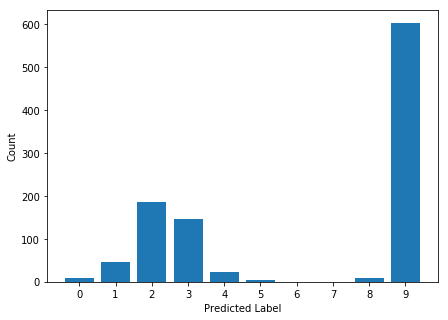

In [5]:
# all images in the test set containing a label label_to_remove
x_unseen_class = x_test_all[np.where(y_test_all==label_to_remove)[0]] 

# make prodictions for class unseen during training
y_pred = model.predict(x_unseen_class)
y_pred_label = get_y_pred_labels(y_pred, class_to_remove=label_to_remove)

# distribution of predicted label
pred_labels, pred_counts = np.unique(y_pred_label,return_counts=True)

# visualization
fig = plt.figure(figsize=(7,5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0,10))
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.savefig("../../Figures/pred-count.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [6]:
# Avarage certitude for unseen class: 1-max_margin
c = []
for i in range(len(y_pred_label)):
    y_probas = np.sort(y_pred[i])  # probabilities for one image
    c.append(y_probas[-1]-y_probas[-2])  # margin

    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

c = np.asarray(c)
pred_acc_high = .95 # 95 % is considered a very high confidence


pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100
print("%.2f%% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 66.72 %
Std accuracy: 32.16 %
28.40% of all predictions made with an accuracy higher than 0.95%


In [7]:
# Avarage certitude for seen class: 1-max_margin
y_pred_seen = model.predict(x_test)
y_pred_label_seen = get_y_pred_labels(y_pred_seen, label_to_remove)

c = []
for i in range(len(y_pred_label_seen)):
    y_probas_seen = np.sort(y_pred_seen[i])  # probabilities for one image
    c.append(y_probas_seen[-1]-y_probas_seen[-2])  # margin

    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

c = np.asarray(c)
pred_acc_high = .95 # 95 % is considered a very high confidence


pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100
print("%.2f %% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 98.64 %
Std accuracy: 8.40 %
96.20 % of all predictions made with an accuracy higher than 0.95%


# Activation weights visualization

(1, 1, 24, 24, 64)


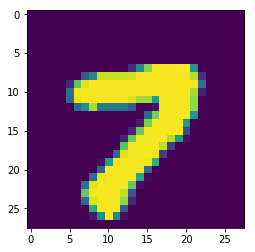

In [8]:
ind_im_test = 10
activations = get_activations(model, 1, x_unseen_class[ind_im_test][np.newaxis,:,:,:])
print(np.shape(activations))
plt.imshow(x_unseen_class[ind_im_test][:,:,0])
plt.show()

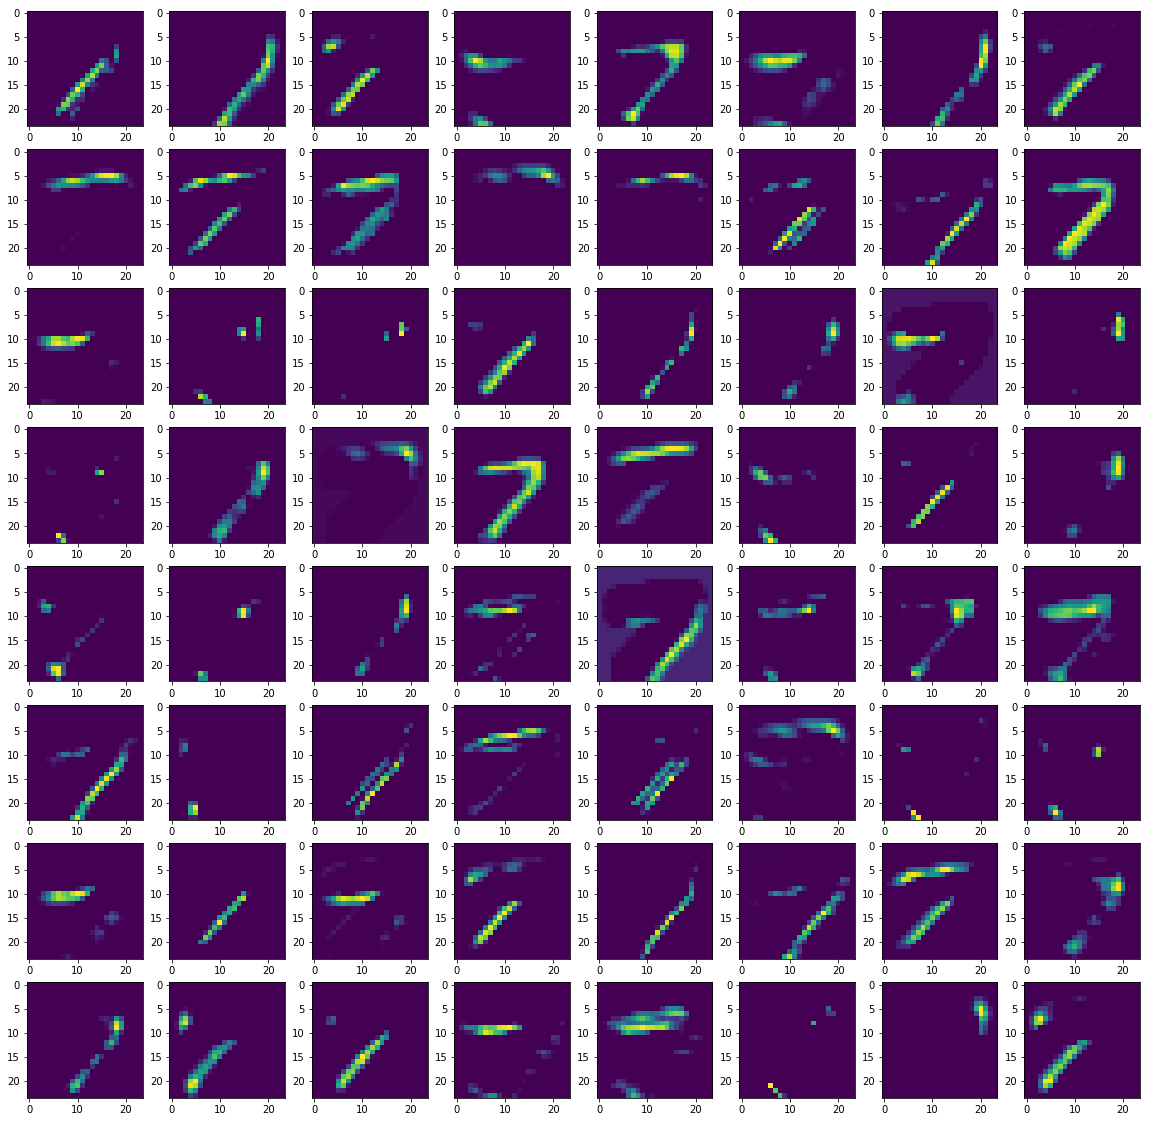

In [9]:
fig, axes = plt.subplots(8,8)
fig.set_size_inches(20,20)
for i in range(8):
    for j in range(8):
        axes[i][j].imshow(activations[0][0][:,:,i*8+j])
plt.show()

In [10]:
# get activation weights of last layer
activations_test = get_activations(model, -2, x_test_all)[0]
print(np.shape(activations_test))

(10000, 128)


# Activations and MLP
Feed activation weigths into density tree

Explained variance ratio by first components:
[0.16686441 0.15664098 0.1449058  0.10983794 0.07910906 0.06175714
 0.03925136 0.03461424 0.0159563  0.0148445  0.01370322 0.01094977
 0.00939907 0.00831586 0.00738304 0.00689922 0.00613916 0.00604285
 0.00553495 0.00450498 0.00418983 0.00403579 0.00365295 0.00352822
 0.00339793 0.00329833 0.00287515 0.00261464 0.00245282 0.00237377
 0.0022772  0.00224639 0.00213773 0.00202609 0.00196267 0.00190364
 0.00181429 0.00168794]
Variance explained by first 38 components: 0.95


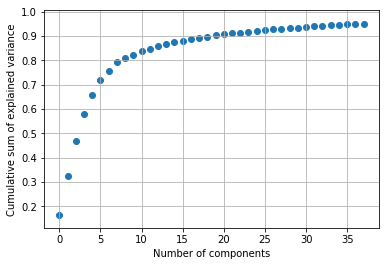

In [11]:
# create density tree for activation weights of training data

dimensions = activations_test.shape[1]
nclusters = 9

# PCA
plt.cla()
pca = decomposition.PCA(n_components=.95)
pca.fit(activations_test)
print("Explained variance ratio by first components:")
print(pca.explained_variance_ratio_)  
print("Variance explained by first %i components: %.2f" % (len(pca.components_), np.sum(pca.explained_variance_ratio_)))
plt.scatter(np.arange(len(pca.components_)), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.savefig("../../Figures/pca_components.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [12]:
x_MLP = pca.transform(activations_test)

In [13]:
y_pred = model.predict(x_test_all)
y_pred_label = get_y_pred_labels(y_pred, label_to_remove)

y_MLP = (y_pred_label == y_test_all)*1

In [14]:
# split training data in train and test part
# split training data in train and test part
indices = np.arange(len(x_MLP))
x_train_MLP, x_test_MLP, y_train_MLP, y_test_MLP, ind_train_MLP, ind_test_MLP = train_test_split(
    x_MLP, y_MLP, indices, test_size=0.5, random_state=42)

In [15]:
# convert class vectors to binary class matrices
num_classes = 2

# convert data to one-hot
y_train_MLP = keras.utils.to_categorical(y_train_MLP, num_classes)
y_test_MLP = keras.utils.to_categorical(y_test_MLP, num_classes)

In [16]:
# KERAS, for GPU use
# Train MLP
n_cl = 2
model_mlp = Sequential()
model_mlp.add(Dense(70, activation='relu', input_shape=(x_train_MLP.shape[1:])))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(70, activation='relu'))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(n_cl, activation='softmax'))

model_mlp.summary()

model_mlp.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

batch_size = 200
epochs = 40
history = model_mlp.fit(x_train_MLP, y_train_MLP,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test_MLP, y_test_MLP))
score = model_mlp.evaluate(x_test_MLP, y_test_MLP, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 70)                2730      
_________________________________________________________________
dropout_3 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 70)                4970      
_________________________________________________________________
dropout_4 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 142       
Total params: 7,842
Trainable params: 7,842
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.0734966509476304
Test accuracy: 0.9822


In [17]:
y_pred = np.argmax(model_mlp.predict(x_test_MLP),-1)
y_test_MLP_label = np.argmax(y_test_MLP, axis=-1)

(array([0.        , 0.12476723, 1.        ]),
 array([0.        , 0.99507058, 1.        ]),
 array([2, 1, 0]))

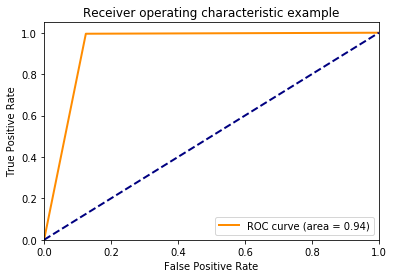

In [18]:
_get_auroc_curve(y_test_MLP_label,y_pred.astype('int'))

Text(0.5,1,'Mean probability to have a correct prediction in class')

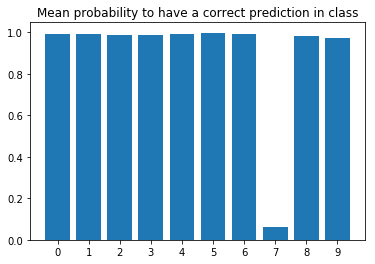

In [19]:
# mean accuracy per class
proba_correct = model_mlp.predict(x_test_MLP)[:,1]  # probability to have a correct prediction

av_p = [np.mean(proba_correct[y_test_all[ind_test_MLP]==i]) for i in 
        range(10)]


plt.bar(range(10), av_p)
plt.xticks(range(10))
plt.title("Mean probability to have a correct prediction in class")

Mean accuracy: 95.36 %
Std accuracy: 16.24 %


Text(0.5,1,'Mean certainty by Network')

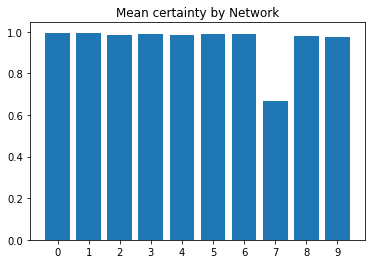

In [20]:
# for comparison: mean margin by network
y_pred = model.predict(x_test_all)

c = get_accuracy_probas(y_pred)
    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

# get mean proba in all 
av_p = [np.mean(c[y_test_all==i]) for i in range(10)]

plt.bar(range(10), av_p)
plt.xticks(range(10))
plt.title("Mean certainty by Network")